## Desription

-  Images are categorized based on the emotion shown in the facial expressions (happiness, neutral, sadness, anger, surprise, disgust, fear).
-  We need to design a CNN which will classify images based on followinf facial expression 

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = './data/'
train_dir = root_dir + 'train/'
test_dir = root_dir + 'test/'

##### Target labels in dataset

In [2]:
target_var = os.listdir(train_dir)
target_var

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

##### Sample Images

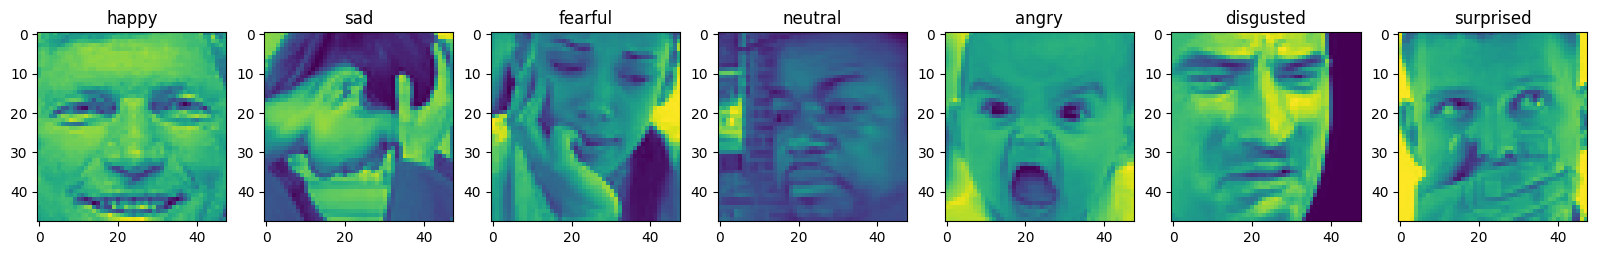

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 7, figsize=(20,8))
for i in range(len(target_var)):
    d = train_dir+target_var[i]+'/'+os.listdir(train_dir+target_var[i]+'/')[0]
    axes[i].imshow( plt.imread(d) )
    axes[i].set_title(target_var[i])
plt.show()

##### EDA

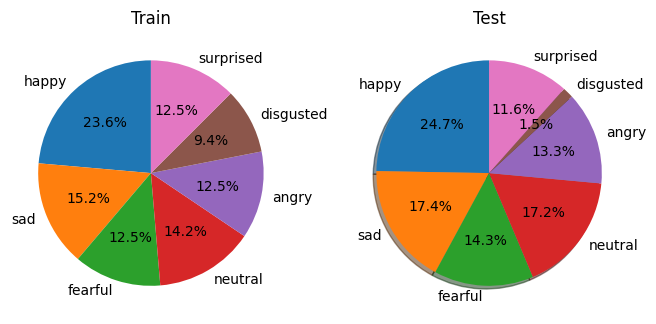

Emotion : happy
	Training : 755
	 Testing : 1774
Emotion : sad
	Training : 485
	 Testing : 1247
Emotion : fearful
	Training : 401
	 Testing : 1024
Emotion : neutral
	Training : 455
	 Testing : 1233
Emotion : angry
	Training : 400
	 Testing : 958
Emotion : disgusted
	Training : 301
	 Testing : 111
Emotion : surprised
	Training : 400
	 Testing : 831


In [4]:
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in target_var ])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for i in target_var ])
label = target_var
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%', startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(test_dir+i+'/'))))


In [5]:
train_count = {expression: len(os.listdir(os.path.join(train_dir, expression))) 
                for expression in os.listdir(train_dir)}
train_count_df = pd.DataFrame(train_count, index=['train'])

test_count = {expression: len(os.listdir(os.path.join(test_dir, expression))) 
               for expression in os.listdir(test_dir)}
test_count_df = pd.DataFrame(test_count, index=['test'])

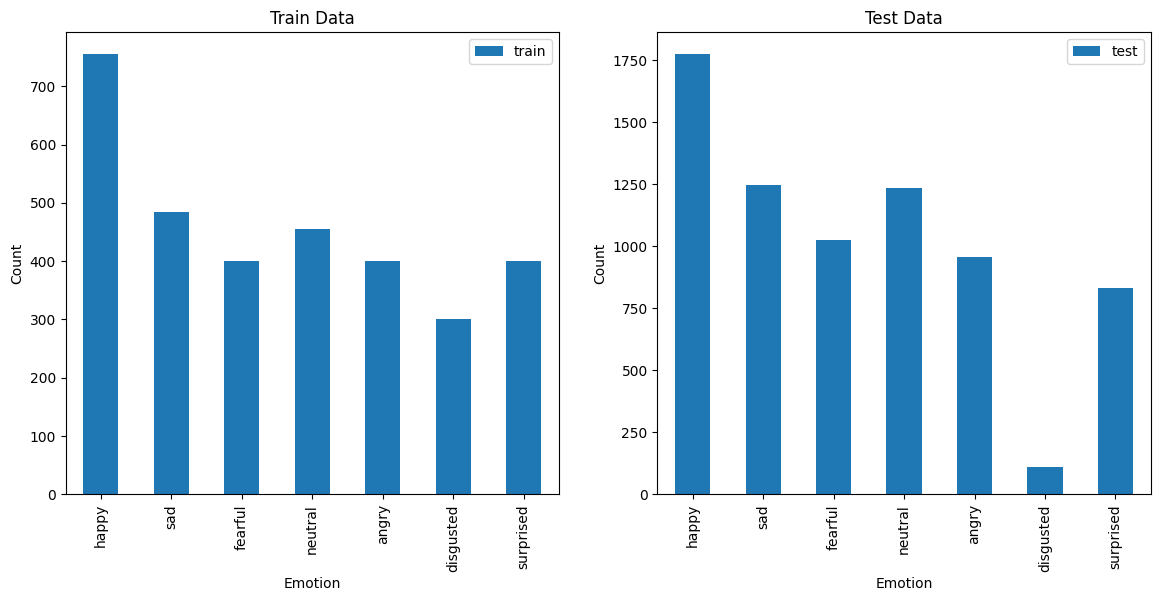

In [6]:
# Plotting data distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_count_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Train Data')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_count_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Test Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

- Male and Females Count.

Emotion : happy
	Training : 7215 - 3270 are male, 3945 are female
	 Testing : 1774 - 835 are male, 939 are female
Emotion : sad
	Training : 4830 - 2530 are male, 2300 are female
	 Testing : 1247 - 666 are male, 581 are female
Emotion : fearful
	Training : 4097 - 2071 are male, 2026 are female
	 Testing : 1024 - 499 are male, 525 are female
Emotion : neutral
	Training : 4965 - 3007 are male, 1958 are female
	 Testing : 1233 -  743 are male, 490 are female
Emotion : angry
	Training : 3995 - 2818 are male, 1177 are female
	 Testing : 958 - 662 are male, 296 are female
Emotion : disgusted
	Training : 436 - 246 are male, 190 are female
	 Testing : 111 - 77 are male, 34 are female
Emotion : surprised
	Training : 3171 - 1576 are male, 1595 are female
	 Testing : 831 - 446 are male, 385 are female

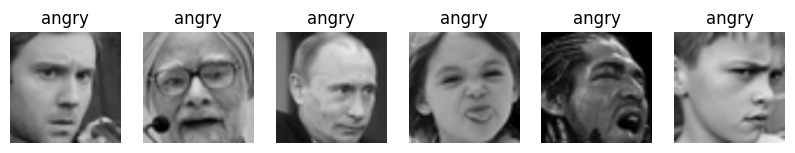

In [35]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Setup directories
train_dir = './data/train'
test_dir = './data/test'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define the size of the dataset and split
total_train = len(train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

def show_images(dataset, indices, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i, idx in enumerate(indices[:num_images]):
        img, label = dataset[idx]
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        ax.set_title(train_dataset.classes[label])
    plt.show()

# Display a few images from the train dataset
indices = [i for i, _ in enumerate(train_dataset)]
show_images(train_dataset, indices)


In [36]:
from torch.utils.data import DataLoader

# Data Loaders
batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
import timm

# Initialize the model
device = torch.device('cpu')
num_classes = len(train_dataset.classes)
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

In [38]:
import torch
import torch.nn as nn
from torch.optim import AdamW

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


In [39]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.train()
    training_stats = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        total_val_accuracy = 0
        
        # Training phase
        for batch_index, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Each batch
            if (batch_index + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_index+1}: Train Loss so far: {total_train_loss / (batch_index + 1)}")

        # Validation phase
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_index, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Validation update for each batch
                if (batch_index + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}, Validation Batch {batch_index+1}: Validation Loss so far: {total_val_loss / (batch_index + 1)}")

            accuracy = 100 * correct / total
            total_val_accuracy = accuracy

        # Store statistics
        training_stats.append({
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'val_accuracy': total_val_accuracy
        })
        
        print(f"Epoch {epoch+1}: Train Loss: {total_train_loss / len(train_loader)}, Val Loss: {total_val_loss / len(val_loader)}, Val Accuracy: {total_val_accuracy}%")
    
    return training_stats

# Call the training function
training_stats = train_model(model, criterion, optimizer, train_loader, val_loader)

Epoch 1, Batch 10: Train Loss so far: 2.072774600982666
Epoch 1, Batch 20: Train Loss so far: 2.0025448560714723
Epoch 1, Batch 30: Train Loss so far: 1.9292044440905254
Epoch 1, Batch 40: Train Loss so far: 1.916301926970482
Epoch 1, Batch 50: Train Loss so far: 1.8928646564483642
Epoch 1, Batch 60: Train Loss so far: 1.8561462541421254
Epoch 1, Batch 70: Train Loss so far: 1.8121244498661586
Epoch 1, Batch 80: Train Loss so far: 1.7735671192407607
Epoch 1, Batch 90: Train Loss so far: 1.744384569591946
Epoch 1, Batch 100: Train Loss so far: 1.7053385061025619
Epoch 1, Batch 110: Train Loss so far: 1.6779526233673097
Epoch 1, Batch 120: Train Loss so far: 1.6497417231400808
Epoch 1, Batch 130: Train Loss so far: 1.6211586777980511
Epoch 1, Batch 140: Train Loss so far: 1.6053511542933327
Epoch 1, Batch 150: Train Loss so far: 1.5853906416893004
Epoch 1, Batch 160: Train Loss so far: 1.5713129691779613
Epoch 1, Validation Batch 10: Validation Loss so far: 1.3393197894096374
Epoch 1, Va

In [40]:
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [41]:
validation_accuracy = validate_model(model, val_loader)

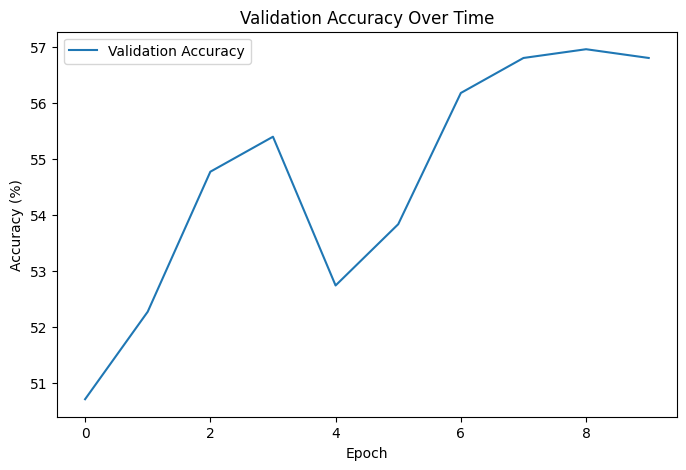

In [42]:
# Plot accuracy or other metrics as needed
plt.figure(figsize=(8, 5))
plt.title('Validation Accuracy Over Time')
plt.plot([x['val_accuracy'] for x in training_stats], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()



#### Print all details about emotions

In [44]:
import torch

def test_model_detailed(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    correct_count = [0] * num_classes
    total_count = [0] * num_classes
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions = (predicted == labels)

            # Update per-class statistics
            for label, prediction in zip(labels, predicted):
                total_count[label] += 1
                if label == prediction:
                    correct_count[label] += 1
            
            # Update total statistics
            total_correct += correct_predictions.sum().item()
            total_samples += labels.size(0)
    
    overall_accuracy = 100 * total_correct / total_samples
    print(f'Test Accuracy: {overall_accuracy:.2f}%')

    return correct_count, total_count, overall_accuracy
    
correct_count, total_count, overall_accuracy = test_model_detailed(model, test_loader, num_classes=len(emotions))
incorrect_count = [total_count[i] - correct_count[i] for i in range(len(total_count))]


Test Accuracy: 58.68%


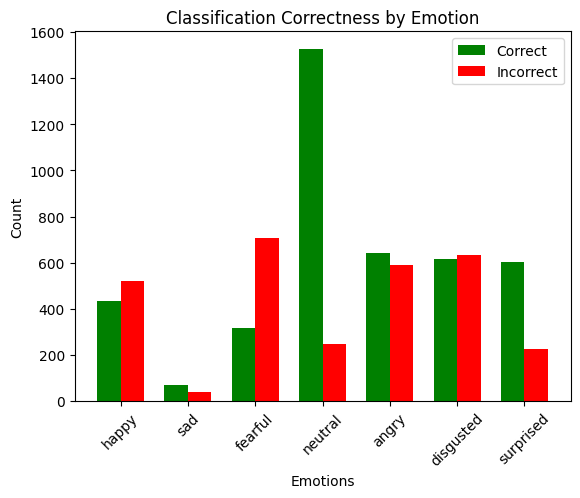

In [45]:
# Define the emotions labels
emotions = ['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

# Define the width of the bars
bar_width = 0.35

# Define the x-axis positions for the bars
x = range(len(emotions))

# Plotting the bars for correct counts
plt.bar(x, correct_count, width=bar_width, label='Correct', color='green')

# Plotting the bars for incorrect counts
plt.bar([i + bar_width for i in x], incorrect_count, width=bar_width, label='Incorrect', color='red')

# Adding labels, title, and custom x-axis tick labels
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Classification Correctness by Emotion')
plt.xticks([i + bar_width / 2 for i in x], emotions, rotation=45)
plt.legend()

# Display the plot
plt.show()